# Sentiment Analysis on Twitter Dataset

## Steps for Analysis as follows
 
 - Importing Required Libraries
 - Loading Dataset
 - Dropping Duplicates or NaN Values from DataFrame
 - Identifying Positive, Negative Tweets using NLP
 - Using count vectorizer and one vs rest approach
 - Tfidf Vectorizer
 - Word embeddings
 - Preformace Metrix

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, SpatialDropout1D, LSTM

import warnings
warnings.filterwarnings('ignore')

### Importing Libraries

In [2]:
df = pd.read_csv(r"D:\Study\Data Science Content\Datasets\Twitter_Data\twitter_data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
df.category.unique()

array([-1.,  0.,  1., nan])

In [4]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [5]:
df[df['category'].isna()]

,clean_text,category
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
159442,chidambaram gives praises modinomics,NaN
160559,the reason why modi contested from seats 2014 ...,NaN


In [6]:
df[df['clean_text'].isna()]

,clean_text,category
148,NaN,0.0
158694,NaN,-1.0
159443,NaN,0.0
160560,NaN,1.0


### Dropping Duplicates or NaN Values from DataFrame

In [7]:
df.drop(df[df['clean_text'].isna()].index, inplace = True)
df.drop(df[df['category'].isna()].index, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


### We will use word cloud for visualization for NLP.

#### Positive Tweets

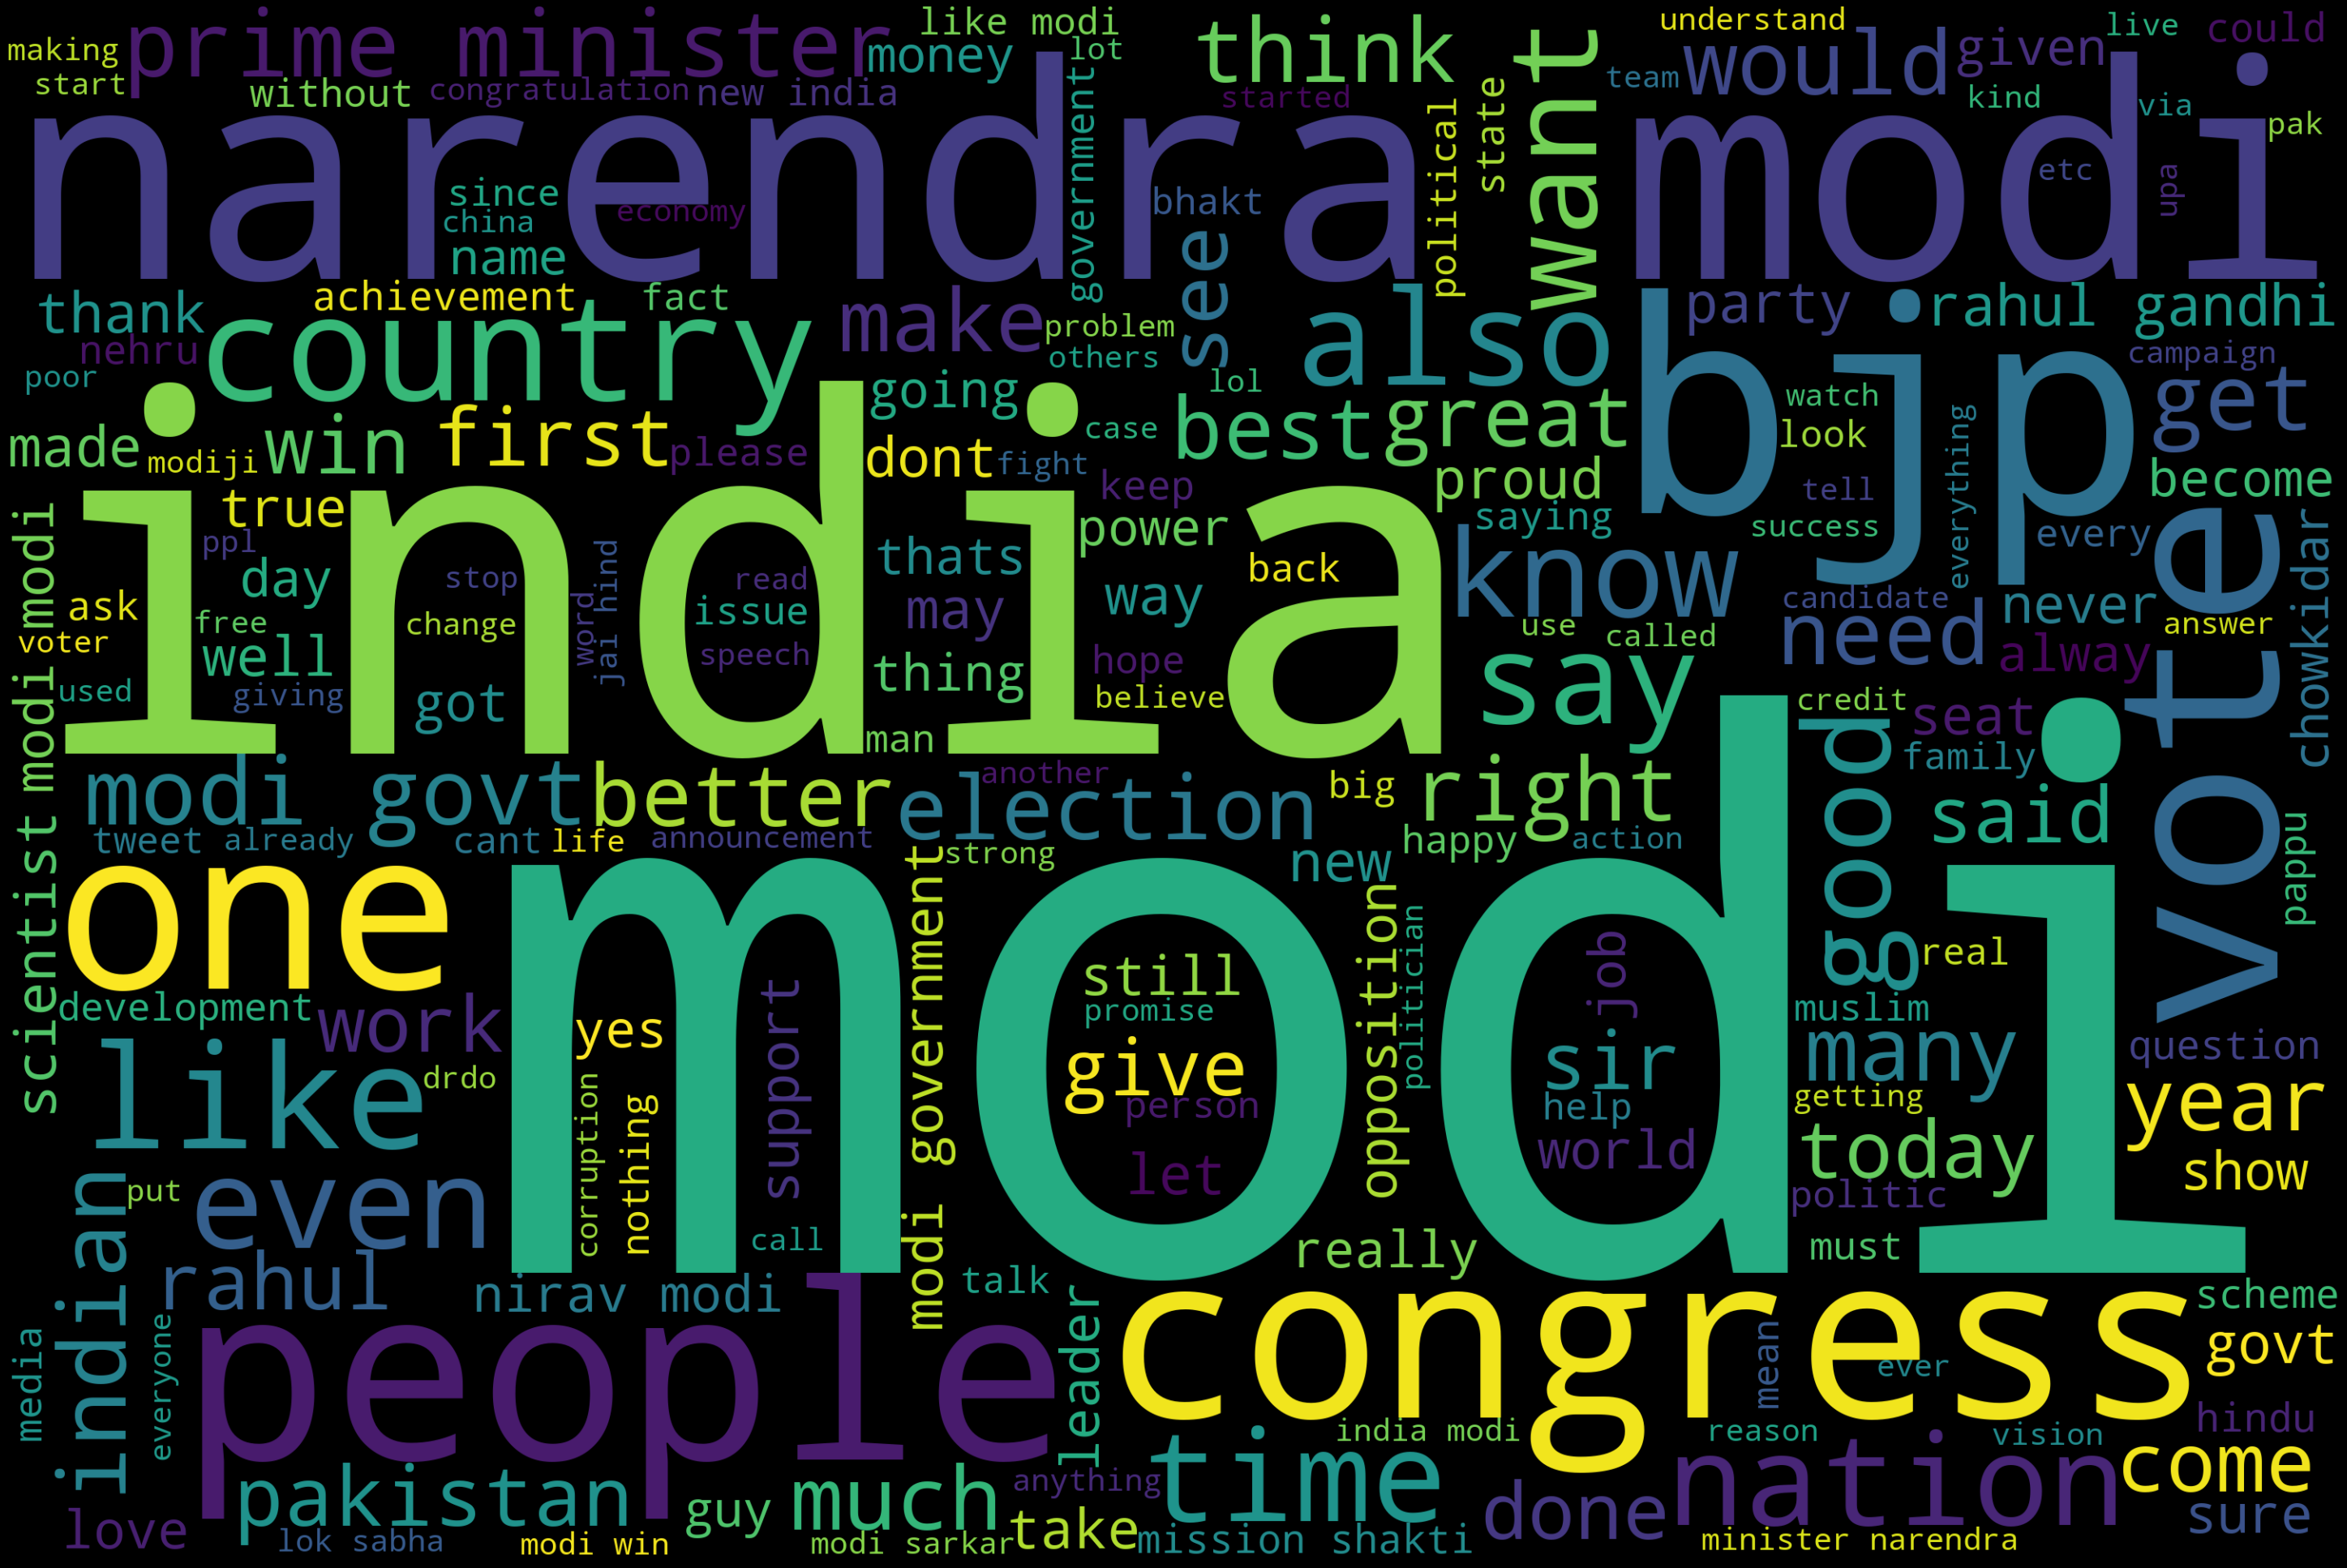

In [9]:
text = ''

for tweet in df[df['category'] == 1.0]['clean_text']:
    text += f" {tweet}"

wordcloud = WordCloud(
    width = 3000, height = 2000, background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show

del text

#### Negative Tweets

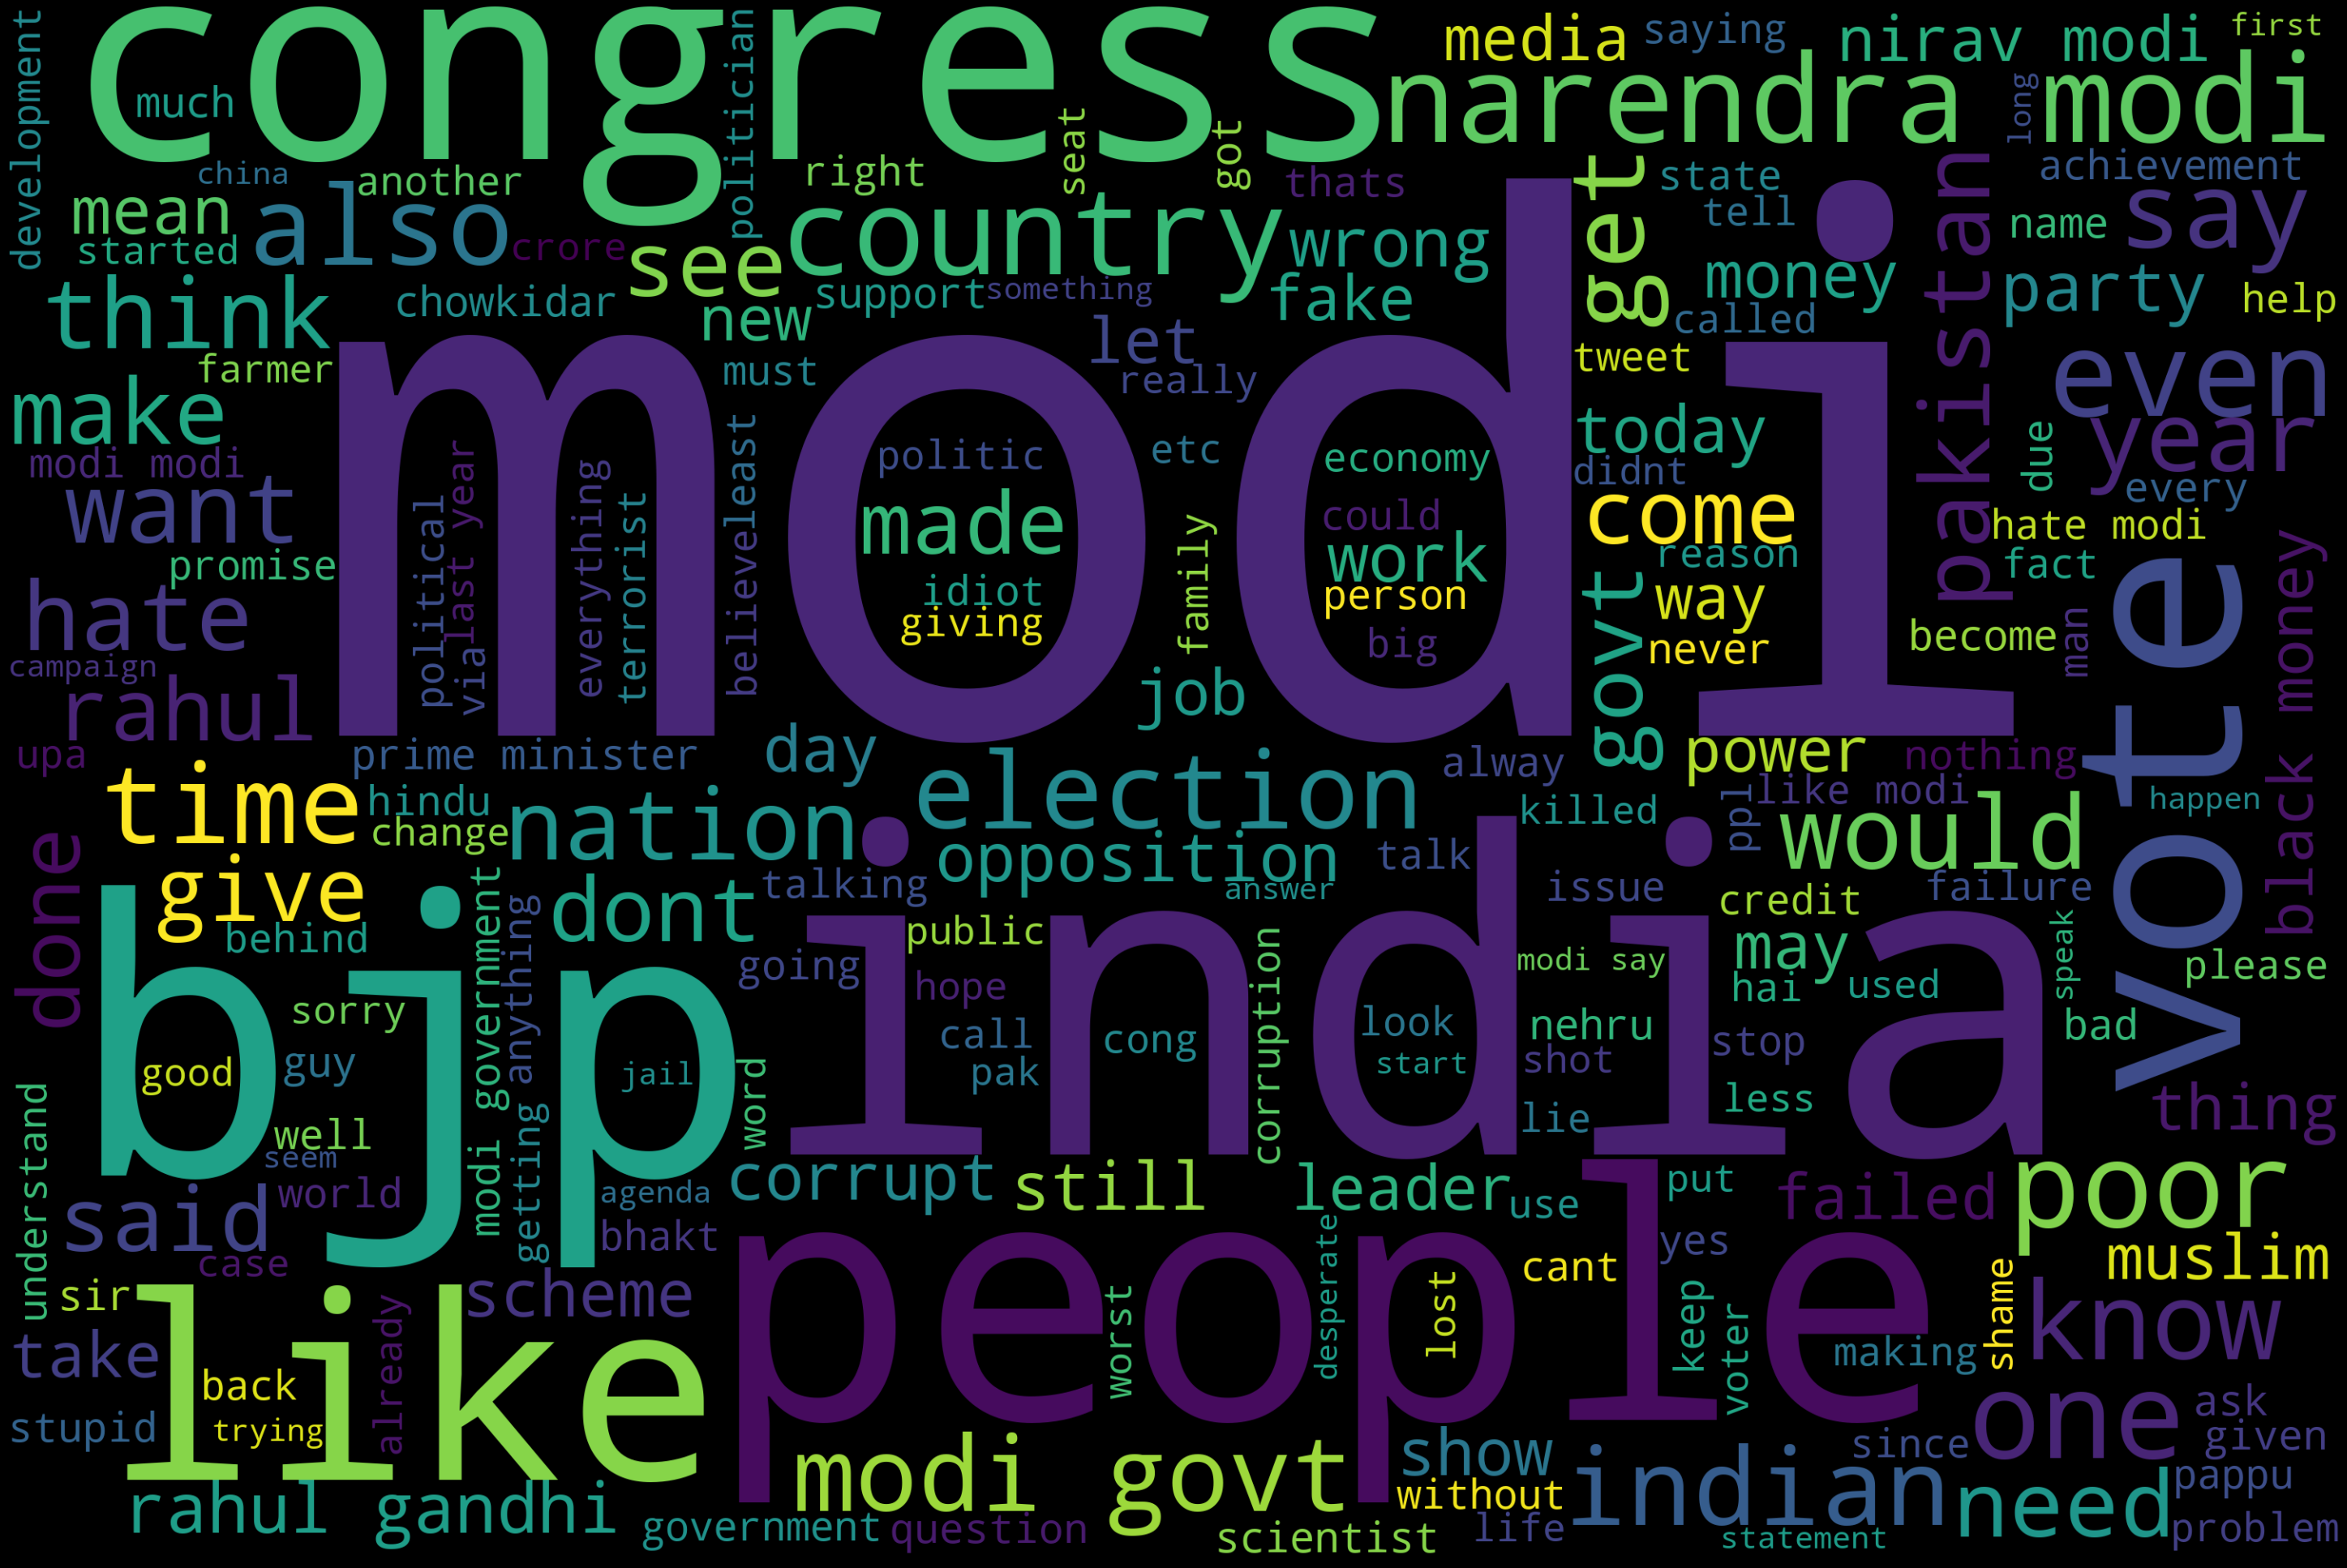

In [10]:
text = ''

for tweet in df[df['category'] == -1.0]['clean_text']:
    text += f" {tweet}"

wordcloud = WordCloud(
    width = 3000, height = 2000, background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words('english'))).generate(text)

fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show

del text

### Using count vectorizer and one vs rest approach

In [11]:
vec = CountVectorizer(max_features = 10000)
vec.fit(df['clean_text'])
trn, val = train_test_split(df, test_size = 0.3, random_state = 42)
trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [12]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs = -1))
clf.fit(trn_abs, trn['category'])
val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average = 'micro')

0.948947659078358

In [13]:
print(clf.score(val_abs, val['category']))

0.948947659078358


In [14]:
accuracy_score(val['category'], val_preds)

0.948947659078358

In [15]:
confusion_matrix(val['category'], val_preds)

array([[ 9572,   264,   855],
       [  198, 16215,   231],
       [  687,   261, 20608]], dtype=int64)

In [16]:
print(classification_report(val['category'], val_preds))

              precision    recall  f1-score   support

        -1.0       0.92      0.90      0.91     10691
         0.0       0.97      0.97      0.97     16644
         1.0       0.95      0.96      0.95     21556

    accuracy                           0.95     48891
   macro avg       0.94      0.94      0.94     48891
weighted avg       0.95      0.95      0.95     48891



### Tfidf Vectorizer

In [17]:
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(df['clean_text']))

trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [18]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn['category'])

val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average='micro')

0.9445501216992903

In [19]:
print(clf.score(val_abs, val['category']))

0.9445501216992903


### Word Embeddings

In [20]:
# Tokenize
tok = Tokenizer(num_words = 1000000)

# Fit
tok.fit_on_texts(df['clean_text'].str.lower().tolist())

vocab_size = len(tok.word_index) + 1

In [21]:
X_trn = tok.texts_to_sequences(trn['clean_text'])
X_val = tok.texts_to_sequences(val['clean_text'])

In [22]:
maxlen = 200
X_trn = pad_sequences(X_trn, maxlen = maxlen)
X_val = pad_sequences(X_val, maxlen = maxlen)

In [23]:
embedding_dim = 50
vocab_size = len(tok.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

model.add(Flatten())
model.add(Dense(200, activation='relu', name = 'Fully_Connected'))
model.add(Dense(1, activation='sigmoid', name = 'Output'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           5683950   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
Fully_Connected (Dense)      (None, 200)               2000200   
_________________________________________________________________
Output (Dense)               (None, 1)                 201       
Total params: 7,684,351
Trainable params: 7,684,351
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_trn, trn['category'], validation_data=(X_val, val['category']), verbose=True, epochs=20, batch_size=256,
          callbacks = [tf.keras.callbacks.ReduceLROnPlateau()])

Epoch 1/20
446/446 [==============================] - 45s 99ms/step - loss: -26.7939 - accuracy: 0.5082 - val_loss: -130.7967 - val_accuracy: 0.5243-25.1765 - ac
Epoch 2/20
446/446 [==============================] - 43s 97ms/step - loss: -697.8732 - accuracy: 0.5644 - val_loss: -1418.4722 - val_accuracy: 0.5614
Epoch 3/20
446/446 [==============================] - 43s 97ms/step - loss: -3352.3303 - accuracy: 0.5651 - val_loss: -4830.7852 - val_accuracy: 0.5454
Epoch 4/20
446/446 [==============================] - 43s 97ms/step - loss: -9019.3027 - accuracy: 0.5659 - val_loss: -11036.7178 - val_accuracy: 0.5585
Epoch 5/20
446/446 [==============================] - 43s 97ms/step - loss: -18337.0742 - accuracy: 0.5653 - val_loss: -20343.4746 - val_accuracy: 0.5585
Epoch 6/20
446/446 [==============================] - 43s 97ms/step - loss: -31734.7930 - accuracy: 0.5658 - val_loss: -33042.9688 - val_accuracy: 0.5441
Epoch 7/20
446/446 [==============================] - 41s 92ms/step - loss

In [25]:
val_preds = model.predict(X_val)

f1_score(val['category'], val_preds, average='micro')

0.5464604937514062

### Performance Metrics

In [26]:
accuracy_score(val['category'], val_preds)

0.5464604937514062

In [28]:
confusion_matrix(val['category'], val_preds)

array([[    0, 10585,   106],
       [    0, 16620,    24],
       [    0, 11459, 10097]], dtype=int64)

In [29]:
print(classification_report(val['category'], val_preds))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00     10691
         0.0       0.43      1.00      0.60     16644
         1.0       0.99      0.47      0.64     21556

    accuracy                           0.55     48891
   macro avg       0.47      0.49      0.41     48891
weighted avg       0.58      0.55      0.48     48891

